# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [3]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self.w = np.random.normal(scale=0.1, size=(in_features + 1, out_features))
        self.x = None
        self.dw = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        self.x = x
        return x @ self.w
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.dw = self.x.T @ d  # градиент по w для gd
        return d @ self.w[1:].T     # градиент по x для backprop
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self.w = self.w - alpha * self.dw

In [4]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        self.x = None
        self.w = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.x = x
        return np.maximum(0, x)
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        y = np.copy(self.x)
        y[y <= 0] = 0
        y[y > 0] = 1
        return np.multiply(d, y)
        
        
class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self, labels):
        self.labels = labels.astype(int)
        self.x = None
        self.w = None
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.x = x
        return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
        
    def backward(self, d) -> np.ndarray: # с учётом кросс-энтропии
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        n = self.x.shape[0]
        sigma = np.exp(self.x) / np.sum(np.exp(self.x), axis=1).reshape(-1, 1)
        delta = np.zeros_like(self.x)
        for i in range(n):
            delta[i, self.labels[i]] = 1
        return (sigma - delta) / n

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [5]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        self.modules = modules
        self.epochs = epochs
        self.learning_rate = alpha
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        self.modules.append(Softmax(y))
        n, dim = X.shape
        m = len(self.modules)
        for _ in range(self.epochs):
#             print('epoch:', epoch)
#             data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
#             np.random.shuffle(data)
            i = 0
            while i < n:
                j = min(i + batch_size, n)
                X_batch, y_batch = X[i: j], y[i: j]
                pred = X_batch
                for module in self.modules:
                    pred = module.forward(pred)
                loss = 1 / (j - i) * self._cross_entropy(pred, y_batch)
#                 print('loss:', loss)
                d = 1
                for k in range(m-1, -1, -1):
                    module = self.modules[k]
                    d = module.backward(d)
                    if module.w is not None:
                        module.update(self.learning_rate)
                i += batch_size
                        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        pred = X
        for module in self.modules:
            pred = module.forward(pred)
        return pred
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)
    
    def _cross_entropy(self, p_pred, y_true):
        eps = 1e-10
        return -np.sum(np.log(np.choose(y_true, p_pred.T) + eps))
        

In [6]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
], epochs=50)

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [17]:
X, y = make_moons(400, noise=0.075)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
], epochs = 500, alpha=0.1)

    p.fit(X_train, y_train, batch_size=100)
    now = np.mean(p.predict(X_val) == y_val)
    print(now)
    best_acc = max(now, best_acc)
print("Validation Accuracy", best_acc)

0.95
0.95
0.925
0.9
0.975
0.975
0.975
0.9
0.95
0.95
0.95
0.925
0.975
0.95
0.95
0.95
0.95
0.95
0.95
0.975
0.975
0.95
0.975
0.975
0.95
Validation Accuracy 0.975


In [18]:
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
], epochs = 500, alpha=0.1)

    p.fit(X, y, batch_size=100)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Test Accuracy", best_acc)

Test Accuracy 0.975


In [19]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 3)
], epochs = 500, alpha=0.01)

    p.fit(X_train, y_train, batch_size=100)
    now = np.mean(p.predict(X_val) == y_val)
    print(now)
    best_acc = max(now, best_acc)
print("Validation Accuracy", best_acc)

0.95
0.9
0.875
0.875
0.975
0.925
0.925
0.95
0.925
0.9
0.925
0.9
0.95
0.925
0.925
0.95
0.9
0.875
0.925
0.925
0.875
0.925
0.95
0.925
0.95
Validation Accuracy 0.975


In [20]:
for _ in range(25):
    p = MLPClassifier([
    Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 3)
], epochs = 500, alpha=0.01)

    p.fit(X, y, batch_size=100)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Test Accuracy", best_acc)

Test Accuracy 0.975


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [22]:
torch.cuda.is_available()

True

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    return F.cross_entropy(model.forward(X), y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [26]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [27]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.1165959647750854 | Test loss 1.9380724075317384
Epoch 1 | Train loss 1.828130182876587 | Test loss 1.7001424089431763
Epoch 2 | Train loss 1.6708462062072753 | Test loss 1.6169080478668212
Epoch 3 | Train loss 1.574471930885315 | Test loss 1.5337366899490357
Epoch 4 | Train loss 1.5183113495254517 | Test loss 1.4887874794006348
Epoch 5 | Train loss 1.4708412606430055 | Test loss 1.4456033168792726
Epoch 6 | Train loss 1.4291574917602539 | Test loss 1.41664913482666
Epoch 7 | Train loss 1.3960656802749634 | Test loss 1.3951904010772704
Epoch 8 | Train loss 1.3745091330718995 | Test loss 1.348584204864502
Epoch 9 | Train loss 1.3416158749008178 | Test loss 1.3341473165512086
Epoch 10 | Train loss 1.325409769935608 | Test loss 1.3088087882995605
Epoch 11 | Train loss 1.3015428237915039 | Test loss 1.3174471700668335
Epoch 12 | Train loss 1.2805204265213013 | Test loss 1.2850650188446044
Epoch 13 | Train loss 1.2578748136901856 | Test loss 1.2578677377700807
Epoch 14

Построим график функции потерь

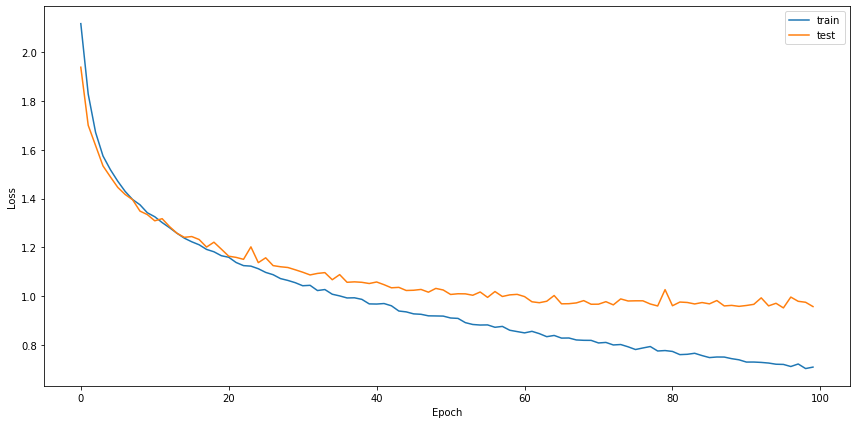

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [29]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6783
Precision [0.75463918 0.75549451 0.60379597 0.46956522 0.59776536 0.62439024
 0.73198847 0.73251029 0.75091241 0.77070064]
Recall [0.732 0.825 0.509 0.54  0.642 0.512 0.762 0.712 0.823 0.726]
Mean Precision 0.6791762278349884
Mean Recall 0.6783
